# Installing Libraries

In [ ]:
!pip install librosa
!pip install seaborn
!pip install tensorflow
!pip install pickle

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
%matplotlib inline

EDA

22050


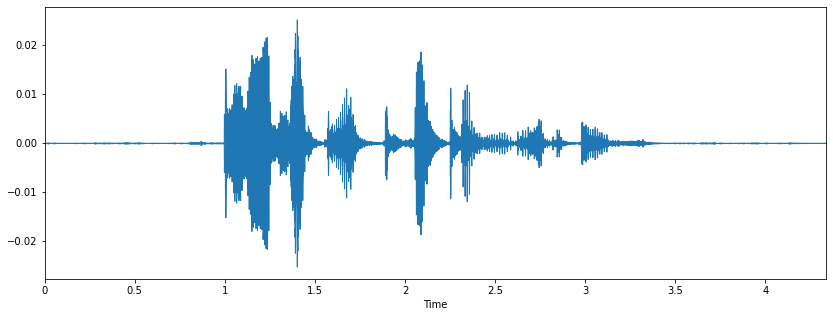

In [3]:
filename='Emotions/Disgusted/03-01-07-01-01-01-05.wav'
plt.figure(figsize=(14,5))
audio_data,sample_rate=librosa.load(filename)
print(sample_rate)
librosa.display.waveplot(audio_data,sr=sample_rate)
ipd.Audio(filename,rate=sample_rate)

# Data Preprocessing

Creating a CSV file to track and use the different files

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd

In [251]:
csv_file=open('Emotions.csv','w',newline='')
writer=csv.writer(csv_file)
keys={"Angry":0,"Disgusted":1,"Fearful":2,"Happy":3,"Neutral":4,"Sad":5,"Suprised":6}
writer.writerow(["File_Name","ClassID","Class"])
file_data=[]
for key in keys:
    file_list=os.listdir("Emotions//"+key)
    for file in file_list:
        row=[file,keys[key],key]
        file_data.append(row)
for row in file_data:
    writer.writerow(row)
csv_file.close()

Feature Extraction Using MFCC( Mel-Frequency Cepstral Coefficients )

MFCC is present as an in-built feature function in librosa library.
It exctracts features from librosa audio file. These features are then used to distinguish between two audio files

In [74]:
def feature_extraction(file_name):
    audio,sample_rate=librosa.load(file_name,res_type='kaiser_fast')
    mfcc_features=librosa.feature.mfcc(y=audio,sr=sample_rate, n_mfcc=60)
    mfcc_scaled_features=np.mean(mfcc_features.T,axis=0)

    return mfcc_scaled_features

In [5]:
import numpy as np
from tqdm import tqdm
import pandas as pd


data=pd.read_csv("Emotions.csv")

extracted_features=[]
for indx_num,row in tqdm(data.iterrows()):
    file_name="Emotions/"+row["Class"]+"/"+row["File_Name"]
    feature=feature_extraction(file_name)
    extracted_features.append([feature,row["Class"]])

12798it [17:14, 12.37it/s]


Converting List to Data Frame

In [ ]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head(10)

Spliting Dataset

In [ ]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
y=np.array(pd.get_dummies(y))

In [8]:
print("x: ",X.shape)
print("y: ",y.shape)

x:  (12798, 60)
y:  (12798, 7)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8958, 60)
(3840, 60)
(8958, 7)
(3840, 7)


# Decision Tree Model

In [8]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier(max_depth=1024)

In [ ]:
from datetime import datetime
starting_time=datetime.now()
dTree.fit(X_train, y_train)
print("Trained model in "+str(datetime.now() - starting_time))

In [34]:
y_pred = dTree.predict(X_test)
print(accuracy_score(y_true=y_test,y_pred=y_pred))

0.48125


In [186]:
#Saving Model
import pickle

pickle.dump(dTree, open("Trained_model_dTree.h5", 'wb'))

In [72]:
from keras.models import load_model

loaded_model_dTree = pickle.load(open("Trained_model_dTree.h5", 'rb'))
filename="Emotions/Happy/03-01-03-02-01-01-07.wav"
prediction_feature=feature_extraction(filename)
prediction_feature=prediction_feature.reshape(1,-1)
rev_keys={0:"Angry",1:"Disgusted",2:"Fearful",3:"Happy",4:"Neutral",5:"Sad",6:"Suprised"}
rev_keys[np.argmax(loaded_model_dTree.predict(prediction_feature),axis=1)[0]]

'Happy'

              precision    recall  f1-score   support

           0       0.61      0.58      0.59       455
           1       0.36      0.35      0.35       364
           2       0.41      0.36      0.38       436
           3       0.40      0.43      0.42       414
           4       0.52      0.54      0.53       367
           5       0.53      0.58      0.56       412
           6       0.61      0.62      0.62       112

   micro avg       0.48      0.48      0.48      2560
   macro avg       0.49      0.49      0.49      2560
weighted avg       0.48      0.48      0.48      2560
 samples avg       0.48      0.48      0.48      2560

[[262  39  45  73  14  14   8]
 [ 22 126  50  59  51  49   7]
 [ 52  48 159  56  41  71   9]
 [ 59  43  55 180  36  28  13]
 [ 18  43  29  39 197  39   2]
 [  9  38  49  34  39 238   5]
 [ 11  11   3  10   1   6  70]]


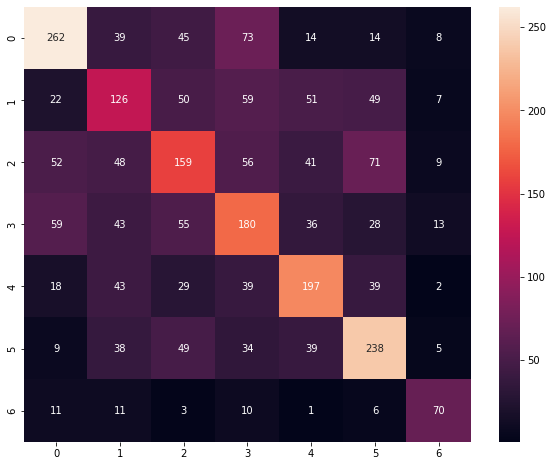

In [35]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sns

print(classification_report(y_test,y_pred))
matrix = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print(matrix)
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d");

# CNN Model Creation

In [64]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,MaxPooling1D,Conv1D
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn import metrics

In [65]:
no_of_labels=y.shape[1]

In [155]:
model=Sequential()

model.add(Conv1D(256,5,padding='same',input_shape=(60,1)))
model.add(Activation('relu'))
model.add(Conv1D(128,5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128,5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128,5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))

opt=tf.keras.optimizers.RMSprop(learning_rate=0.00001,decay=1e-6)

In [156]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 60, 256)           1536      
_________________________________________________________________
activation_100 (Activation)  (None, 60, 256)           0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 60, 128)           163968    
_________________________________________________________________
activation_101 (Activation)  (None, 60, 128)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 60, 128)           0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 7, 128)          

In [157]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

In [158]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_traincnn.shape, x_testcnn.shape

((10238, 60, 1), (2560, 60, 1))

Training CNN Model

In [159]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs=100
num_batch_size=32

checkpointer = ModelCheckpoint(filepath='audio_classification.hdf5',verbose=0,save_best_only=True)

start_time=datetime.now()

history=model.fit(x_traincnn,y_train,batch_size=num_batch_size,epochs=num_epochs,validation_data=(x_testcnn,y_test),callbacks=[checkpointer])

run_time=datetime.now()-start_time
print("Training Finished in:",run_time)

Epoch 1/100
320/320 [==============================] - 23s 63ms/step - loss: 1.8584 - accuracy: 0.2467 - val_loss: 1.6731 - val_accuracy: 0.3277
Epoch 2/100
320/320 [==============================] - 14s 42ms/step - loss: 1.6748 - accuracy: 0.3271 - val_loss: 1.5860 - val_accuracy: 0.3695
Epoch 3/100
320/320 [==============================] - 16s 51ms/step - loss: 1.5874 - accuracy: 0.3682 - val_loss: 1.5155 - val_accuracy: 0.4137
Epoch 4/100
320/320 [==============================] - 16s 50ms/step - loss: 1.5341 - accuracy: 0.3940 - val_loss: 1.4719 - val_accuracy: 0.4320
Epoch 5/100
320/320 [==============================] - 14s 44ms/step - loss: 1.4899 - accuracy: 0.4152 - val_loss: 1.4387 - val_accuracy: 0.4441
Epoch 6/100
320/320 [==============================] - 16s 49ms/step - loss: 1.4577 - accuracy: 0.4227 - val_loss: 1.4304 - val_accuracy: 0.4340
Epoch 7/100
320/320 [==============================] - 15s 47ms/step - loss: 1.4306 - accuracy: 0.4348 - val_loss: 1.3854 - val_ac

In [202]:
test_accuracy=model.evaluate(x_testcnn,y_test,verbose=0)
print(test_accuracy[1])

0.5980468988418579


Saving the Trained Model

In [161]:
model.save('Trained_model_CNN.h5')

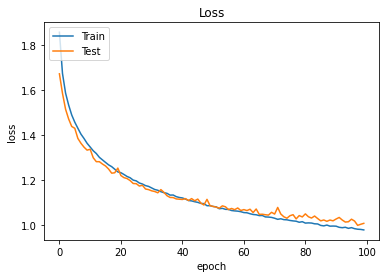

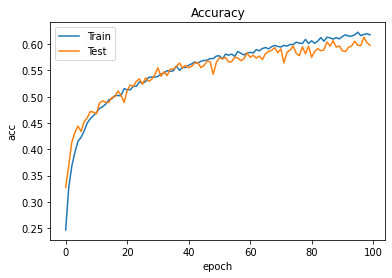

In [162]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

C:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      0.54      0.67       455
           1       0.93      0.22      0.35       364
           2       0.85      0.31      0.45       436
           3       0.88      0.34      0.49       414
           4       0.86      0.44      0.58       367
           5       0.83      0.47      0.60       412
           6       0.91      0.77      0.83       112

   micro avg       0.87      0.41      0.55      2560
   macro avg       0.88      0.44      0.57      2560
weighted avg       0.87      0.41      0.54      2560
 samples avg       0.41      0.41      0.41      2560

[[433   2   7  10   0   1   2]
 [261  79   5   2   9   4   4]
 [266   0 135   6   4  25   0]
 [257   0   9 142   1   4   1]
 [197   1   1   0 162   6   0]
 [200   2   2   1  12 193   2]
 [ 25   1   0   0   0   0  86]]


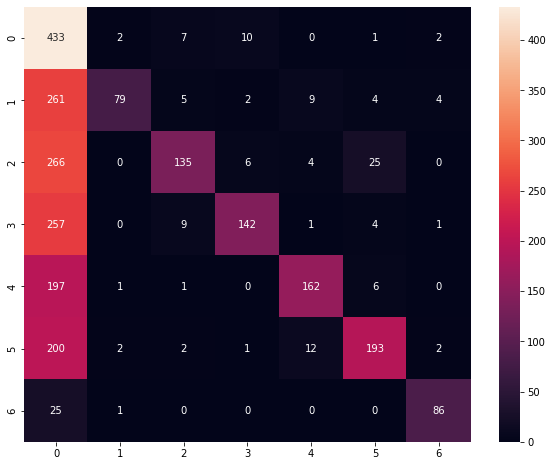

In [163]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

predictions = (model.predict(x_testcnn) > 0.5).astype("int32")
y_test = y_test.astype(int)
report = classification_report(y_test, predictions)
print(report)
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print (matrix)

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d");

testing a sample file

In [71]:
from tensorflow.keras.models import load_model

loaded_model_CNN = load_model("Trained_model_CNN.h5")
filename="Emotions/Happy/03-01-03-02-02-01-05.wav"
prediction_feature=feature_extraction(filename)
prediction_feature=prediction_feature.reshape(1,-1)
prediction_feature=np.expand_dims(prediction_feature, axis=2)
rev_keys={0:"Angry",1:"Disgusted",2:"Fearful",3:"Happy",4:"Neutral",5:"Sad",6:"Suprised"}
rev_keys[np.argmax(loaded_model_CNN.predict(prediction_feature),axis=1)[0]]

'Happy'

# MLP Model Creation 

In [134]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

MLP = MLPClassifier(alpha=0.01,batch_size=32,epsilon=1e-08,hidden_layer_sizes=(128,128,128,64,64),learning_rate='adaptive',max_iter=500)
mlp_history=MLP.fit(X_test, y_test)
y_pred=MLP.predict(X_test)

C:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [182]:
#Saving Model
import pickle

pickle.dump(MLP, open("Trained_model_MLP.h5", 'wb'))

In [632]:
print(accuracy_score(y_true=y_test,y_pred=y_pred))

0.9174479166666667


              precision    recall  f1-score   support

           0       1.00      0.87      0.93       679
           1       0.96      0.96      0.96       549
           2       0.94      0.97      0.95       634
           3       0.88      0.97      0.92       593
           4       0.93      0.97      0.95       579
           5       0.95      0.93      0.94       628
           6       0.99      0.95      0.97       178

   micro avg       0.94      0.94      0.94      3840
   macro avg       0.95      0.95      0.95      3840
weighted avg       0.95      0.94      0.94      3840
 samples avg       0.93      0.94      0.93      3840

[[610   1  12  45   6   5   0]
 [ 13 527   1   1   4   3   0]
 [ 12   1 611   5   1   4   0]
 [ 10   4   4 572   2   1   0]
 [  9  10   6   2 551   1   0]
 [ 29   4  11   4  11 569   0]
 [  4   1   1   3   4   0 165]]


C:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


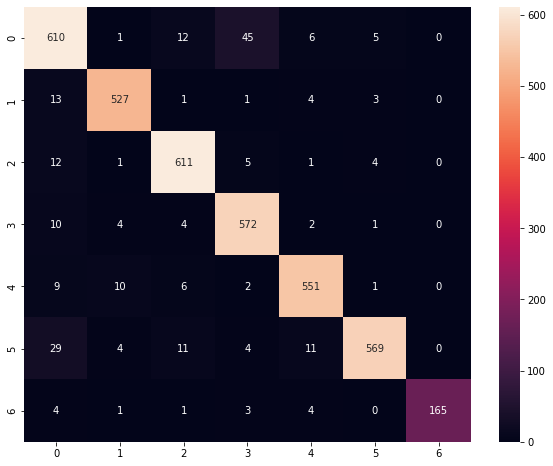

In [633]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test,y_pred))
matrix = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print (matrix)
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d");

testing data

In [66]:
import pickle

filename="Emotions/Suprised/03-01-08-01-01-01-10.wav"
loaded_model_MLP = pickle.load(open("Trained_model_MLP.h5", 'rb'))
prediction_feature=feature_extraction(filename)
prediction_feature=prediction_feature.reshape(1,-1)
rev_keys={0:"Angry",1:"Disgusted",2:"Fearful",3:"Happy",4:"Neutral",5:"Sad",6:"Suprised"}
print(rev_keys[np.argmax(loaded_model_MLP.predict(prediction_feature),axis=1)[0]])

Suprised
